# Exploring venues in Chandigarh, India

## Table of Contents

* [Introduction](#introduction)
* [Data Collection from APIs](#data_collection)
* [Data Cleaning](#data_cleaning)
* [Methodolgy](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

The aim of the project is to identify venues in Chandigarh, India based on their rating and average prices. In this notebook, we will identify various venues in the city of **Chandigarh, India**, using **Foursquare API** and **Zomato API**, to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Here, we'll **identify places that are fit for various individuals** based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

## Data Collection from APIs <a name="data_collection"></a>

To begin with, we will take a look at **Chandigarh on the Map** using the `folium` library.

We will also fetch the data from **two different APIs**.
* **Foursquare API:** We will use the Foursquare API to fetch venues in Chandigarh starting from the middle upto 44 Kilometers in each direction.
* **Zomato API:** The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

### Chandigarh

**Chandigarh** is composed of a number of sectors spread across a total area of 114 sq Km. There are many venues (especially restaurants, hotels and cafes) which can be explored.

In [10]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
print('Libraries imported.')

Libraries imported.


In [11]:
address = 'Chandigarh, IN'

geolocator = Nominatim(user_agent="explore_chandigarh")
location = geolocator.geocode(address)
chn_latitude = location.latitude
chn_longitude = location.longitude
print('The geograpical coordinates of Chandigarh are {}, {}.'.format(chn_latitude, chn_longitude))

The geograpical coordinates of Chandigarh are 30.7194022, 76.7646552.


In [12]:
import folium

chandigarh_map = folium.Map(location = [chn_latitude, chn_longitude], zoom_start = 13)
folium.Marker([chn_latitude, chn_longitude]).add_to(chandigarh_map)
chandigarh_map.save("ChandigarhMap.html")
chandigarh_map

### Foursquare API

We begin by fetching a total of all venues in **Chandigarh** upto a range of 4 Kilometers using the Foursquare API. The Foursquare API has the `explore` API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [13]:
FOURSQUARE_CLIENT_ID = '1BMK0S0BM3WY0AYZDHI3LGVTPHBALBFWQG0U14W20T1TQNIP'
FOURSQUARE_CLIENT_SECRET = 'UZDRGEAKSNAXCYN54101V3NQ3U0KYPZ34QDUN2XTRAV3GQFB'
RADIUS = 5000 # 5 Km
NO_OF_VENUES = 200
VERSION = '20200613' # Current date

We define the `get_category_type` method to get the correct category for each venue.

In [14]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

* Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account. 
* We will set the radius as 5 Kilometers. 
* The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [16]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        chn_latitude, 
                                                                        chn_longitude, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    result
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 5.0 Km
Total 30 venues fetched within a total radius of 5.0 Km

Total 130 venues fetched


### Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the `name`, `lat`, and `lng` values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

* The query will be the name of the venue.
* The start defines from what offset we want to start, so we'll keep it at 0.
* The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
* We will supply the latitude and longitude values.
* We will set the sorting criteria as `real_distance` so each time we get the venue we're searching based on location coordinates.

In [17]:
headers = {'user-key': 'bcdac661e67a4af4bbd56c804d0624af'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])


Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [19]:
zomato_venues.dtypes

venue             object
latitude          object
longitude         object
price_for_two    float64
price_range      float64
rating            object
address           object
dtype: object

In [20]:
zomato_venues[zomato_venues['longitude'] == 0]

,venue,latitude,longitude,price_for_two,price_range,rating,address
10,0,0,0,0.0,0.0,0,None
36,0,0,0,0.0,0.0,0,None
43,0,0,0,0.0,0.0,0,None
77,0,0,0,0.0,0.0,0,None
87,0,0,0,0.0,0.0,0,None


The analysis of zomato_venues dataframe revealed that the ratings, Latitude and Longitudes were captured as Object type. For using ratings, Latitude and Longitudes in further analysis, these columns have to be of Float type. Hence I have converted them from Object to Float64.

Apart from that there are few records in zomato_venues dataframe with all values zero. Hence we dropped those rows

In [21]:
zomato_venues=zomato_venues[zomato_venues['longitude'] != 0]
zomato_venues['latitude'] = pd.to_numeric(zomato_venues['latitude'])
zomato_venues['longitude'] = pd.to_numeric(zomato_venues['longitude'])
zomato_venues['rating'] = pd.to_numeric(zomato_venues['rating'])
zomato_venues.dtypes

venue             object
latitude         float64
longitude        float64
price_for_two    float64
price_range      float64
rating           float64
address           object
dtype: object

## Data Cleaning <a name="data_cleaning"></a>

The data from multiple resources might not always align. Thus, it is **important to combine the data retrieved from multiple resources properly**.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [22]:
chandigarh_map = folium.Map(location = [chn_latitude, chn_longitude], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(chandigarh_map)  

chandigarh_map.save("Venues_from_Foursquare.html")
chandigarh_map

From the map, we can infer that there are significant clusters of venues around **Sector 35**, **Sector 17** and **Elante Mall**. We can also plot the category count and see the major type of venues that exist.

We will also plot the Zomato data on the map.

In [23]:
chandigarh_map = folium.Map(location = [chn_latitude, chn_longitude], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(venue, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(chandigarh_map)  

chandigarh_map.save("Venues_from_Zomato.html")
chandigarh_map

We can see that there are many venues identified by both Foursquare and Zomato. There is a lot of overlapping between the two near Sector 35, Sector 17, Sector 26 and Elante Mall. However, there are others where the data does not match just like the red dots in the bottom right on the second map.

To combine the two datasets, I had to ensure that the latitude and longitude values of each corresponding venue match. Hence, I first rounded both the latitude and longitude values upto 4 decimal places. Then, I calculated the difference between the corresponding latitude and longitude values and checked if the difference is less than 0.0004 which ideally mean that the two locations are same.

The venues for which the difference was more than 0.0004 were dropped.

In [24]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [25]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']
dataset.shape[0]

130

In [26]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues.shape[0]

69

In [27]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

I'll drop the venues which have `0.0` rating as it means it's not been rated yet.

In [28]:
selected_venues=selected_venues[selected_venues['rating']!=0].reset_index(drop = True)
selected_venues.shape[0]
print("Total venues available after cleaning and filtering : {}".format(selected_venues.shape[0]))

Total venues available after cleaning and filtering : 63


Let's take a look at the final dataset that is left with us.

In [29]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Bakery,Nik Baker's,30.7216,76.7601,2.0,4.5,"SCO 441 - 442, Sector 35 C, Sector 35, Chandigarh",450.0
1,Coffee Shop,Starbucks Coffee,30.7299,76.7732,2.0,4.0,"Sector 22 C, Near Sector 22, Chandigarh",250.0
2,American Restaurant,OvenFresh,30.7217,76.7604,2.0,4.7,"SCO 437 & 438, Sector 35 C, Sector 35, Chandigarh",425.0
3,Bakery,Classic 44,30.7148,76.7517,1.0,3.3,"SCO 413, Sector 44 D, Near Sector 44, Chandigarh",100.0
4,Hotel Bar,McDonald's,30.7302,76.7737,2.0,4.3,"Himalaya Marg, Sector 22 C, Near Sector 22, Ch...",250.0


## Methodology <a name="methodology"></a>

This project aims at identifying the venues in Chandigarh based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the **data from two APIs (Foursquare and Zomato)**. We extracted venue information from the center of Chandigarh, upto a distance of 5 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

In a second step, we **explored the data** retrieved from the two APIs on the map and identified the top category types. The **data from the two sources is carefully combined** based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we **analysed the data** that we created based on the ratings and price of each venue. We **identified the places where many venues are located** so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We also explored **areas that are high rated and those that are low rated** while also plotting the **map of high and low priced venues**. Lastly, we **clustered the venues** based on the available information of each venue. This allowed us to clearly identify which venues can be recommended and with what characteristics.

Finally, we have discussed and concluded which venues to be explored based on visitor requirement of rating and cost.

## Analysis <a name="analysis"></a>

The complete dataset is now in its final form. 

We will **inspect these venues based on their rating**. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also **analyse the venues based on their price per person as well as the price range**. 

### Categories

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 29 artists>

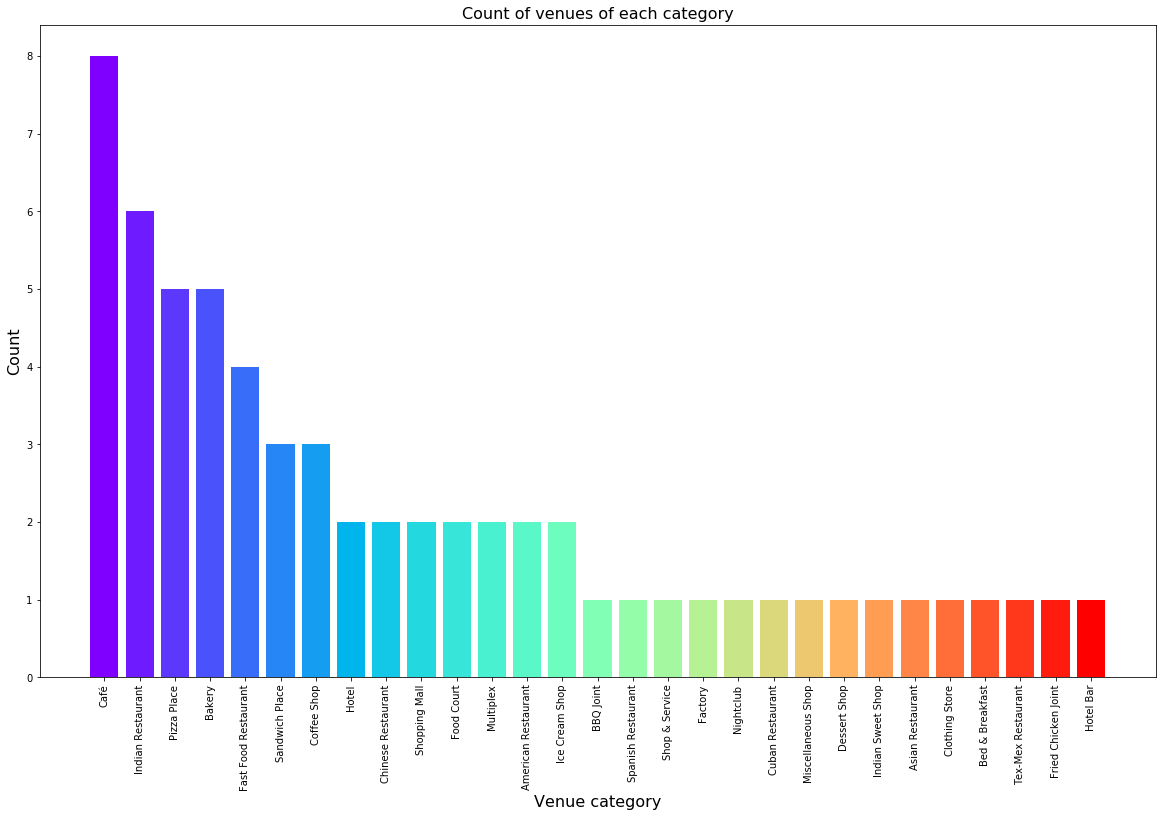

In [30]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are **Cafe** and **Indian Restaurant**. So, if as a tourist, you're looking for cafes and Indian restaurants, you're in luck.

### Rating

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

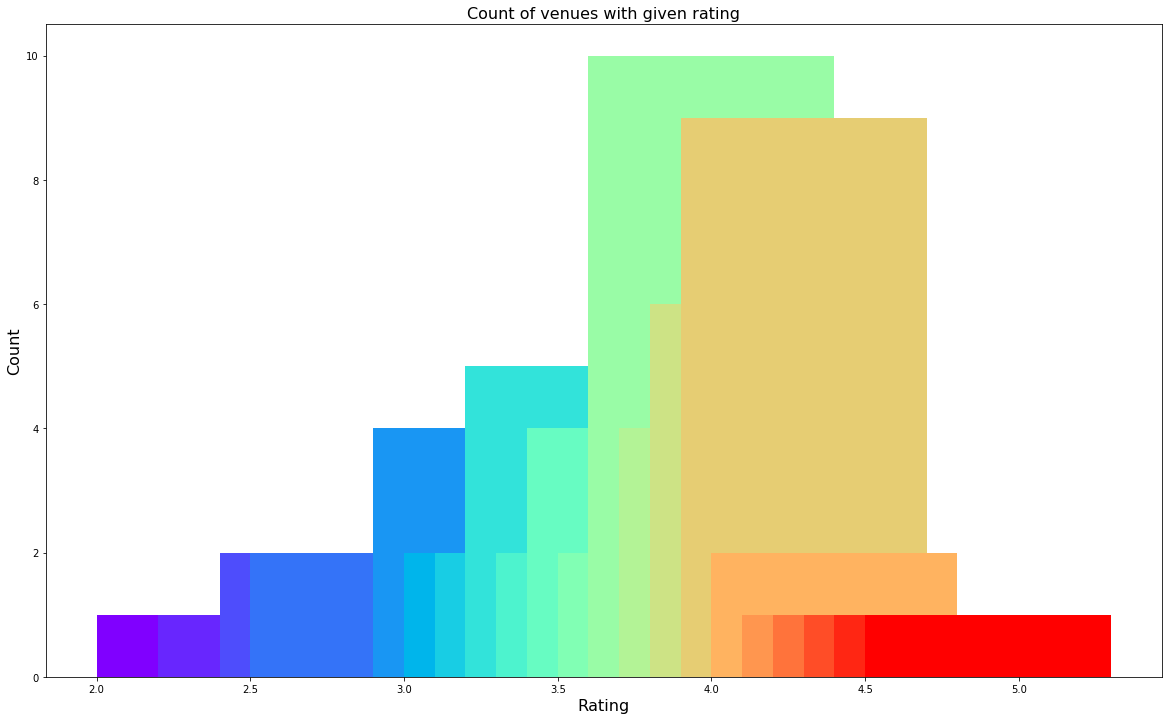

In [31]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that **majority venues** have their **rating close to 4**.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:
* 1 to 2
* 2 to 3
* 3 to 4
* 4 to 5

In [32]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Now, we will plot the venues on the map.

In [33]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'blue', 'Very good': 'green'}

chandigarh_map = folium.Map(location = [chn_latitude, chn_longitude], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(chandigarh_map)  

chandigarh_map.save("Venues_Ratings.html")
chandigarh_map

The map has the location of all the venues. It appears that many venues are located near about **Sector 35**, **Sector 17** and **Elante Mall** with rating above 3. If someone wants to explore new venues, they should definitely check out Sector 35, Sector 17 or Elante Mall.

### Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is `average_price` which defines the average cost for one person and the other is `price_range` which determines the price range as defined by Zomato.

We will first explore the `average_price` using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

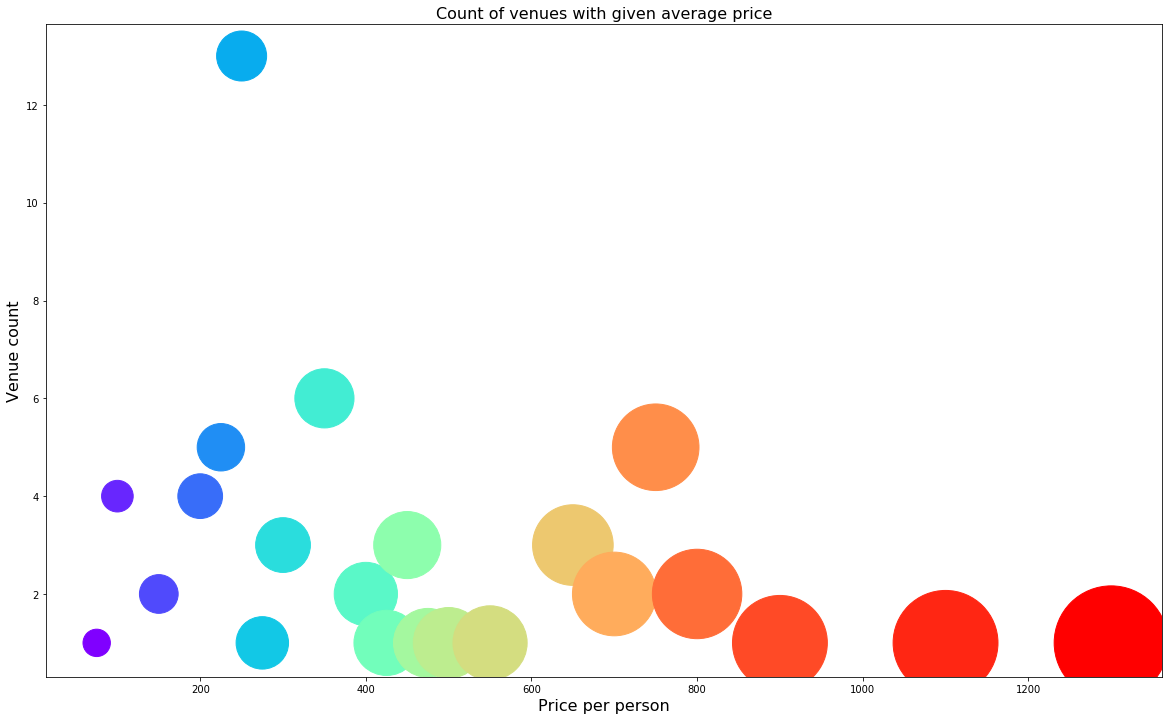

In [34]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a large number of venues have an average price between Rs 200 and Rs 400.

Users might also be interested in going to a place that fits in their budget. I'll use the `price_range` column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [35]:
color_map = {'1.0': 'green', '2.0': 'blue', '3.0': 'orange', '4.0': 'red'}

chandigarh_map = folium.Map(location = [chn_latitude, chn_longitude], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(chandigarh_map)  

chandigarh_map.save("Venues_Prices.html")
chandigarh_map

1. The venues near Sector 35 and Sector 17 are primarily lower priced.
2. The venues near Sector 7 and Sector 26 have steep prices.
3. Elante Mall seems to have a mix of both high priced and low priced venues.

### Clustering

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [36]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Bakery,Nik Baker's,30.7216,76.7601,2.0,4.5,"SCO 441 - 442, Sector 35 C, Sector 35, Chandigarh",450.0,Very good
1,0,Coffee Shop,Starbucks Coffee,30.7299,76.7732,2.0,4.0,"Sector 22 C, Near Sector 22, Chandigarh",250.0,Good
2,0,American Restaurant,OvenFresh,30.7217,76.7604,2.0,4.7,"SCO 437 & 438, Sector 35 C, Sector 35, Chandigarh",425.0,Very good
3,0,Bakery,Classic 44,30.7148,76.7517,1.0,3.3,"SCO 413, Sector 44 D, Near Sector 44, Chandigarh",100.0,Good
4,0,Hotel Bar,McDonald's,30.7302,76.7737,2.0,4.3,"Himalaya Marg, Sector 22 C, Near Sector 22, Ch...",250.0,Very good


In [37]:
chandigarh_map = folium.Map(location = [chn_latitude, chn_longitude], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(chandigarh_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(chandigarh_map)

chandigarh_map.save("Venues_Clusters.html")
chandigarh_map

From the map, we see the two clusters:
1. The first cluster is spread across the whole city and includes the majority venues.
2. The second cluster is very sparsely spread and has very limited venues.

I'll also check the venues of the two clusters.

In [39]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Bakery,Nik Baker's,30.7216,76.7601,2.0,4.5,"SCO 441 - 442, Sector 35 C, Sector 35, Chandigarh",450.0,Very good
1,0,Coffee Shop,Starbucks Coffee,30.7299,76.7732,2.0,4.0,"Sector 22 C, Near Sector 22, Chandigarh",250.0,Good
2,0,American Restaurant,OvenFresh,30.7217,76.7604,2.0,4.7,"SCO 437 & 438, Sector 35 C, Sector 35, Chandigarh",425.0,Very good
3,0,Bakery,Classic 44,30.7148,76.7517,1.0,3.3,"SCO 413, Sector 44 D, Near Sector 44, Chandigarh",100.0,Good
4,0,Hotel Bar,McDonald's,30.7302,76.7737,2.0,4.3,"Himalaya Marg, Sector 22 C, Near Sector 22, Ch...",250.0,Very good
5,0,Café,Barista,30.7223,76.7613,2.0,3.8,"SCO 422, Sector 35 C, Sector 35, Chandigarh",300.0,Good
6,0,Shopping Mall,McDonald's,30.7056,76.8013,2.0,4.2,"321, 3rd Floor, Elante Mall, Chandigarh Indust...",250.0,Very good
7,0,Clothing Store,Biryani Blues,30.7057,76.8006,2.0,3.6,"Elante Mall, Plot 178, Phase-I, Chandigarh Ind...",350.0,Good
8,0,Ice Cream Shop,Softy Corner,30.7405,76.7816,1.0,4.6,"SCO 87, Sector 17, Chandigarh",200.0,Very good
9,0,Sandwich Place,Nik Baker's,30.7479,76.7933,2.0,4.3,"Booth 31-34, Inner Market, Sector 9 D, Near Se...",450.0,Very good


In [40]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.68 and rating spread around 3.82


In [41]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,BBQ Joint,Barbeque Nation,30.7256,76.8053,3.0,4.9,"SCO 39, Madhya Marg, Sector 26, Chandigarh",650.0,Very good
1,1,Multiplex,Pyro,30.7235,76.7677,3.0,3.8,"Ground Floor, Piccadilly Square Mall, Block A,...",800.0,Good
2,1,Chinese Restaurant,Mainland China,30.7256,76.8053,3.0,4.2,"SCO 40, Madhya Marg, Sector 26, Chandigarh",750.0,Very good
3,1,Chinese Restaurant,The Great Kabab Factory,30.7253,76.8058,3.0,4.0,"SCO 43, Madhya Marg, Sector 26, Chandigarh",800.0,Good
4,1,Nightclub,Kings Cross - The Altius Boutique Hotel,30.7006,76.7920,4.0,3.4,"The Altius Hotel, 25/9, Phase 2, Chandigarh In...",1300.0,Good
5,1,American Restaurant,Brooklyn Central,30.7049,76.8011,3.0,4.4,"51A, Courtyard, Ground Floor, Elante Mall, Pha...",650.0,Very good
6,1,Spanish Restaurant,Casa Bella Vista Pizzeria,30.7547,76.7872,3.0,4.0,"Coal Depot, Backide Market, Sector 10 D, Near ...",700.0,Good
7,1,Cuban Restaurant,Virgin Courtyard,30.7348,76.7977,4.0,4.8,"SCO 1A, Behind Madhya Marg, Sector 7C, Near Se...",1100.0,Very good
8,1,Tex-Mex Restaurant,Cafe Delhi Heights,30.7062,76.8009,3.0,3.9,"Unit 315, Plot 178-178A, Elante Mall, 3rd Floo...",900.0,Good
9,1,Café,Cafe Nomad,30.7330,76.8033,3.0,4.0,"178, Inner Market, Sector 7, Chandigarh",750.0,Good


In [42]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 3.12 and rating spread around 4.04


#### Results and Discussion <a name="results"></a>

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of Chandigarh, India.

After collecting data from the **Foursquare** and **Zomato** APIs, we got a list of 130 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 63.

We identified that from the total set of venues, majority of them were **Cafes** and **Indian Restaurants**. A visitor who loves Cafes/Indian Restaurants would surely benefit from coming to Chandigarh.

While the complete range of ratings range from 1 to 5, the **majority venues have ratings close to 4**. This means that most restaurants provide **good quality food** which is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we discover that there are clusters of venues around **Sector 17, Sector 35 and Elante Mall**. These clusters also have very **high ratings (more than 3)**.

When we take a look at the price values of each venue, we explore that **many venues** have prices which are in the **range of Rs 200 to Rs 400 for one person**. However, the variation in prices is very large, given the complete range starts from Rs 100 and goes uptil Rs 1200. On plotting the venues based on their price range on the map, we discovered that venues located near **Sector 17 and Sector 35 are relatively priced lower than venues in Sector 7 and Sector 26**. A **mix of low price and high price exist in Elante Mall**.

Finally, through clusters we identified that there are **many venues** which are **relatively lower priced but have an average rating of 3.82**. On the other hand, there are **few venues** which are **high priced and have average rating of 4.04**.

1. If you're looking for cheap places with relatively high rating, you should check **Sector 35**.
2. If you're looking for the best places, with the highest rating but might also carry a high price tag, you should visit **Sector 7** and **Sector 26**.
3. If you're looking to explore the city and have no specific criteria to decide upon the places you want to visit, you should try **Elante Mall**.

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price). They can also use this information to setup a new restaurant/Hotel/Cafe.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to explore the places that a person visiting Chandigarh could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are three major areas a person can visit: Sector 35, Sector 7 & 26 and Elante Mall. Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.